In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import graphviz
import xgboost as xgb
import pickle as pk

In [2]:
# Carregar o dataset MNIST
mnist = load_digits()
X, y = mnist.data, mnist.target
y = y.astype(int)

# Dividir o dataset em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
tree_model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini'],   
    'max_depth': [6, 10], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados pelo GridSearch:")
print(grid_search.best_params_)

best_tree_model = grid_search.best_estimator_
y_pred = best_tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do melhor modelo no conjunto de teste: {accuracy * 100:.2f}%")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=6, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=g

In [4]:
# Criar e treinar o modelo XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=10, 
    eval_metric='mlogloss', 
    eta=0.3, 
    max_depth=6, 
    n_estimators=11,
    random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo XGBoost: {accuracy*100:.2f}%')

Acurácia do modelo XGBoost: 96.11%


<Figure size 5000x5000 with 0 Axes>

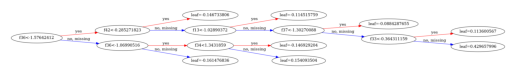

In [5]:
booster = xgb_model.get_booster()

# Definir o número da árvore que você quer visualizar
num_trees = booster.best_iteration if hasattr(booster, 'best_iteration') else booster.num_boosted_rounds()

# Plotar a árvore final
plt.figure(figsize=(50, 50))
xgb.plot_tree(booster, num_trees=num_trees - 1, rankdir='LR')  # -1 porque os índices são 0-based
plt.savefig('arvore_xgb_final.png', format='png', dpi=600) 
plt.show()

In [6]:
# Criar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo Random Forest: {accuracy * 100:.2f}%')

Acurácia do modelo Random Forest: 96.11%


In [7]:
# Escolha a árvore que você deseja visualizar (por exemplo, a primeira árvore)
tree_index = 0  # O índice da árvore que você deseja visualizar
estimator = rf_model.estimators_[tree_index]

# Exportar a árvore para o formato DOT
dot_data = export_graphviz(
    estimator,
    out_file=None,
    feature_names=mnist.feature_names,
    class_names=[str(i) for i in range(10)],
    filled=True,
    rounded=True,
    special_characters=True
)

# Gerar e visualizar o gráfico usando graphviz
graph = graphviz.Source(dot_data)
graph.render('arvore_rf_final', format='svg')  # Salva como tree.svg

gini = estimator.tree_.impurity
print("Índices de Gini nos nós da árvore:", gini)

Índices de Gini nos nós da árvore: [0.89932682 0.74981886 0.54014757 0.11989796 0.01868993 0.
 0.         0.61111111 0.         0.44444444 0.         0.
 0.7415625  0.42722117 0.         0.265      0.         0.44444444
 0.64389043 0.13717421 0.         0.         0.59555556 0.12444444
 0.51555556 0.61080314 0.66644628 0.50413223 0.69387755 0.625
 0.         0.         0.3067034  0.         0.27777778 0.
 0.         0.25816349 0.1089876  0.625      0.5        0.
 0.02352608 0.         0.         0.48513674 0.         0.
 0.87800273 0.61719233 0.53070348 0.31052863 0.16100519 0.10133918
 0.375      0.66272189 0.67283951 0.21875    0.66050296 0.39669421
 0.         0.         0.49732302 0.         0.34775087 0.20216049
 0.15673469 0.         0.05876951 0.         0.32       0.
 0.86054299 0.80623233 0.73535892 0.58414278 0.40132231 0.53921875
 0.59837271 0.29271553 0.29930796 0.56419593 0.22812649 0.05386752
 0.65277778 0.72482639 0.58       0.41581633 0.82185031 0.56009049
 0.73555556 0

In [8]:
# Salvar o modelo treinado
with open('dec_tree.pkl', 'wb') as f:
    pk.dump(best_tree_model, f)